In [1]:
# import models
import math,time,linearmodels
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


In [2]:
# import data
df = pd.read_csv("./dateData/allSalesData.csv")

In [3]:
# data cleaning information
discount_map = {
    0: 100,
    1: 10,
    5: 50,
    7: 70,
    9: 90
}
type_map={
    "topsales":0,
    "newsales":1,
    "presales":2
}
cate_map = {        #以下可以混合參考
    1: "文學小說",
    2: "商業理財",
    3: "藝術設計",
    4: "人文社科",
    6: "自然科普",
    7: "心理勵志",
                    #
    8: "醫療保健",
    9: "飲食",
    10: "生活風格",
    11: "旅遊",
    12: "宗教命理",
    13: "親子教養",
                        #獨立看
    14: "青少年文學",   
    15: "輕小說",       #
    16: "漫畫、圖文書",  #
    19: "電腦資訊",
    22: "影視偶像",
    
                        #以下不計
    17: "語言學習",
    18: "考試用書",     #
    20: "專業出版品",    #
    24: "國中小參考書"    #
}
cate_eng_map = {
    1:'Literature & Fiction',
    2:'Business & Money',
    3:'Arts & Photography',
    4:'Politics & Social Sciences',
    6:'Science & Math',
    7:'Self-Help',
    8:'Health, Fitness & Dieting',
    9:'Health, Fitness & Dieting',
    10:'Cookbooks, Food & Wine',
    11:'Travel',
    12:'Religion & Spirituality',
    13:'Parenting & Relationships',
    14:'Teen & Young Adult',
    15:'Literature & Fiction',
    16:'Comics & Graphic Novels',
    19:'Computers & Technology',
    22:'Humor & Entertainment',
    17:'Education & Teaching',
    18:'Test Preparation',
    20:'Education & Teaching',
    24:'Education & Teaching'
}
    


In [4]:
# clean data ----- discount to int
df['discount'] = df["discount"].fillna(0).astype(str)
temp = []
for _ in df['discount']:
    if math.ceil(float(_)) in  discount_map:
        temp.append(discount_map[math.ceil(float(_))])
    else:
        temp.append(math.ceil(float(_)))
df['discount'] = temp


In [5]:
# clean data ----- type to int
temp = []
for _ in df['type']:
    temp.append(type_map[_])
df['type'] = temp

In [6]:
# clean data ----- date, title, attr, cate
df['date'] = [time.strftime("%Y-%m-%d",time.strptime(i,"%Y-%m-%d %H:%M:%S")) for i in df['date']]
df['date_'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
# df['title'] = [hash(i) for i in df['title']]
df['attr'] = [math.ceil(i) for i in df['attr'].fillna(0)]
df['cate'] = [math.ceil(i) for i in df['cate'].fillna(0)]
df['publishDate_'] = pd.to_datetime(df['publishDate'], format='%Y-%m-%d')

In [7]:
# choose needed columns
df = df[['title','rank','cate','attr','date','discount','type','price_','publishDate_','publisher']]

In [8]:
#df.drop(["type"],axis=1).drop(["date"],axis=1).groupby('cate').mean()
"""
std_df = df.drop(["type"],axis=1).drop(["date"],axis=1)
std_df['discount'] = (std_df['discount'] - std_df['discount'].mean())/ std_df['discount'].std()
std_df['price_'] = (std_df['price_'] - std_df['price_'].mean())/ std_df['price_'].std()
"""
#std_df.cov()
#df.drop(["date"],axis=1).groupby('type').mean()

'\nstd_df = df.drop(["type"],axis=1).drop(["date"],axis=1)\nstd_df[\'discount\'] = (std_df[\'discount\'] - std_df[\'discount\'].mean())/ std_df[\'discount\'].std()\nstd_df[\'price_\'] = (std_df[\'price_\'] - std_df[\'price_\'].mean())/ std_df[\'price_\'].std()\n'

In [9]:
for i in cate_map:
    print(f"cate {i} : {cate_map[i]}")
    #print(df[df['cate'] == i].groupby('type').count().iloc[:,0],end="\n\n")
    print(df[df['cate'] == i].loc[:,'discount'].mean(),end="\n\n")

cate 1 : 文學小說
78.74072072072072

cate 2 : 商業理財
78.53873873873874

cate 3 : 藝術設計
80.11756220699603

cate 4 : 人文社科
79.31436363636364

cate 6 : 自然科普
79.29860609189468

cate 7 : 心理勵志
78.67891891891892

cate 8 : 醫療保健
79.09959146618247

cate 9 : 飲食
78.61269404598153

cate 10 : 生活風格
79.12378774016469

cate 11 : 旅遊
78.03397699693996

cate 12 : 宗教命理
79.71018018018017

cate 13 : 親子教養
79.49397722295225

cate 14 : 青少年文學
77.13549549549549

cate 15 : 輕小說
86.26

cate 16 : 漫畫、圖文書
87.93333333333334

cate 17 : 語言學習
80.07648648648649

cate 18 : 考試用書
84.18126126126126

cate 19 : 電腦資訊
78.92954356078141

cate 20 : 專業出版品
92.87157817380121

cate 22 : 影視偶像
82.00478167862086

cate 24 : 國中小參考書
nan


In [10]:
df['title'] = df['title'].astype("category")

In [11]:
# choose data of major types, and prepare the data to regress
Y = pd.DataFrame([])
X = df[['attr','cate']]
X['attr'] = X['attr'].astype("category")
X['cate'] = X['cate'].astype("category")
X = pd.get_dummies(X[['attr','cate']],drop_first=True)
X['rank'] = pd.to_numeric(df['rank'])
X['price'] = pd.to_numeric( df['price_'])
Y['discount'] = pd.to_numeric(df['discount'])
X['days_since_start'] = (df['publishDate_'] -  datetime.datetime.strptime("2024-04-22",'%Y-%m-%d')).dt.days
X = X.fillna(False)
Y = Y.fillna(False)
X['days_since_start'] = X['days_since_start'].astype(int)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224831 entries, 0 to 224830
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   attr_7            224831 non-null  bool 
 1   attr_30           224831 non-null  bool 
 2   cate_1            224831 non-null  bool 
 3   cate_2            224831 non-null  bool 
 4   cate_3            224831 non-null  bool 
 5   cate_4            224831 non-null  bool 
 6   cate_6            224831 non-null  bool 
 7   cate_7            224831 non-null  bool 
 8   cate_8            224831 non-null  bool 
 9   cate_9            224831 non-null  bool 
 10  cate_10           224831 non-null  bool 
 11  cate_11           224831 non-null  bool 
 12  cate_12           224831 non-null  bool 
 13  cate_13           224831 non-null  bool 
 14  cate_14           224831 non-null  bool 
 15  cate_15           224831 non-null  bool 
 16  cate_16           224831 non-null  bool 
 17  cate_17   

/var/folders/3p/81nnp2994m19w63h0mm8m4bc0000gn/T/ipykernel_2425/3471261878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['attr'] = X['attr'].astype("category")
/var/folders/3p/81nnp2994m19w63h0mm8m4bc0000gn/T/ipykernel_2425/3471261878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cate'] = X['cate'].astype("category")


In [12]:
# Convert boolean columns in X to integer type (since True/False are essentially 1/0)
for col in X.columns[X.dtypes == 'bool']:
    X[col] = X[col].astype(int)
X_const = sm.add_constant(X)
model = sm.OLS(Y, X_const).fit()

# Displaying the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               discount   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     4217.
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        14:38:06   Log-Likelihood:            -7.1103e+05
No. Observations:              224831   AIC:                         1.422e+06
Df Residuals:                  224805   BIC:                         1.422e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               81.4783      0.059  

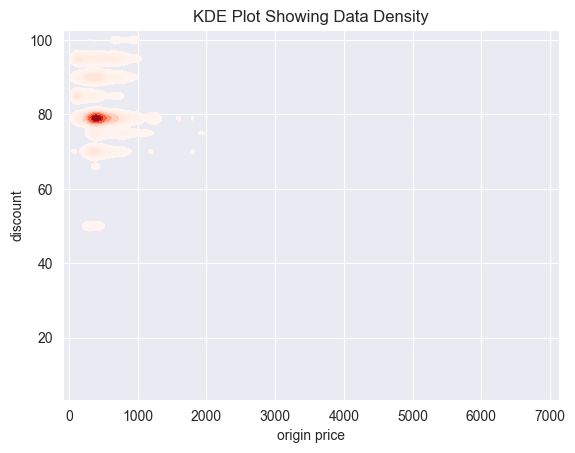

In [13]:
# show the relationship between price and discount 
import seaborn as sns
df['initprice'] = [df['price_'].at[i]/df['discount'].at[i] * 100 for i in range(len(df)) ]
#df['std_discount'] = [df['discount'].at[i] - df['discount'].mean()/df['discount'].std() for i in range(len(df))]

sns.kdeplot(x=df['initprice'], y=df['discount'], cmap="Reds", fill=True)
plt.title('KDE Plot Showing Data Density')
plt.xlabel('origin price')
plt.savefig("./pics/KDE_plot_inipric.png",dpi=300)


In [14]:
# show the distribution of discount
df.groupby('discount').count().iloc[:,0]

discount
6           1
10          4
50       1435
66        984
70      12999
72         94
73        112
75       9201
76         18
77        454
79     146292
85       9291
90      21820
95      19662
100      2464
Name: title, dtype: int64

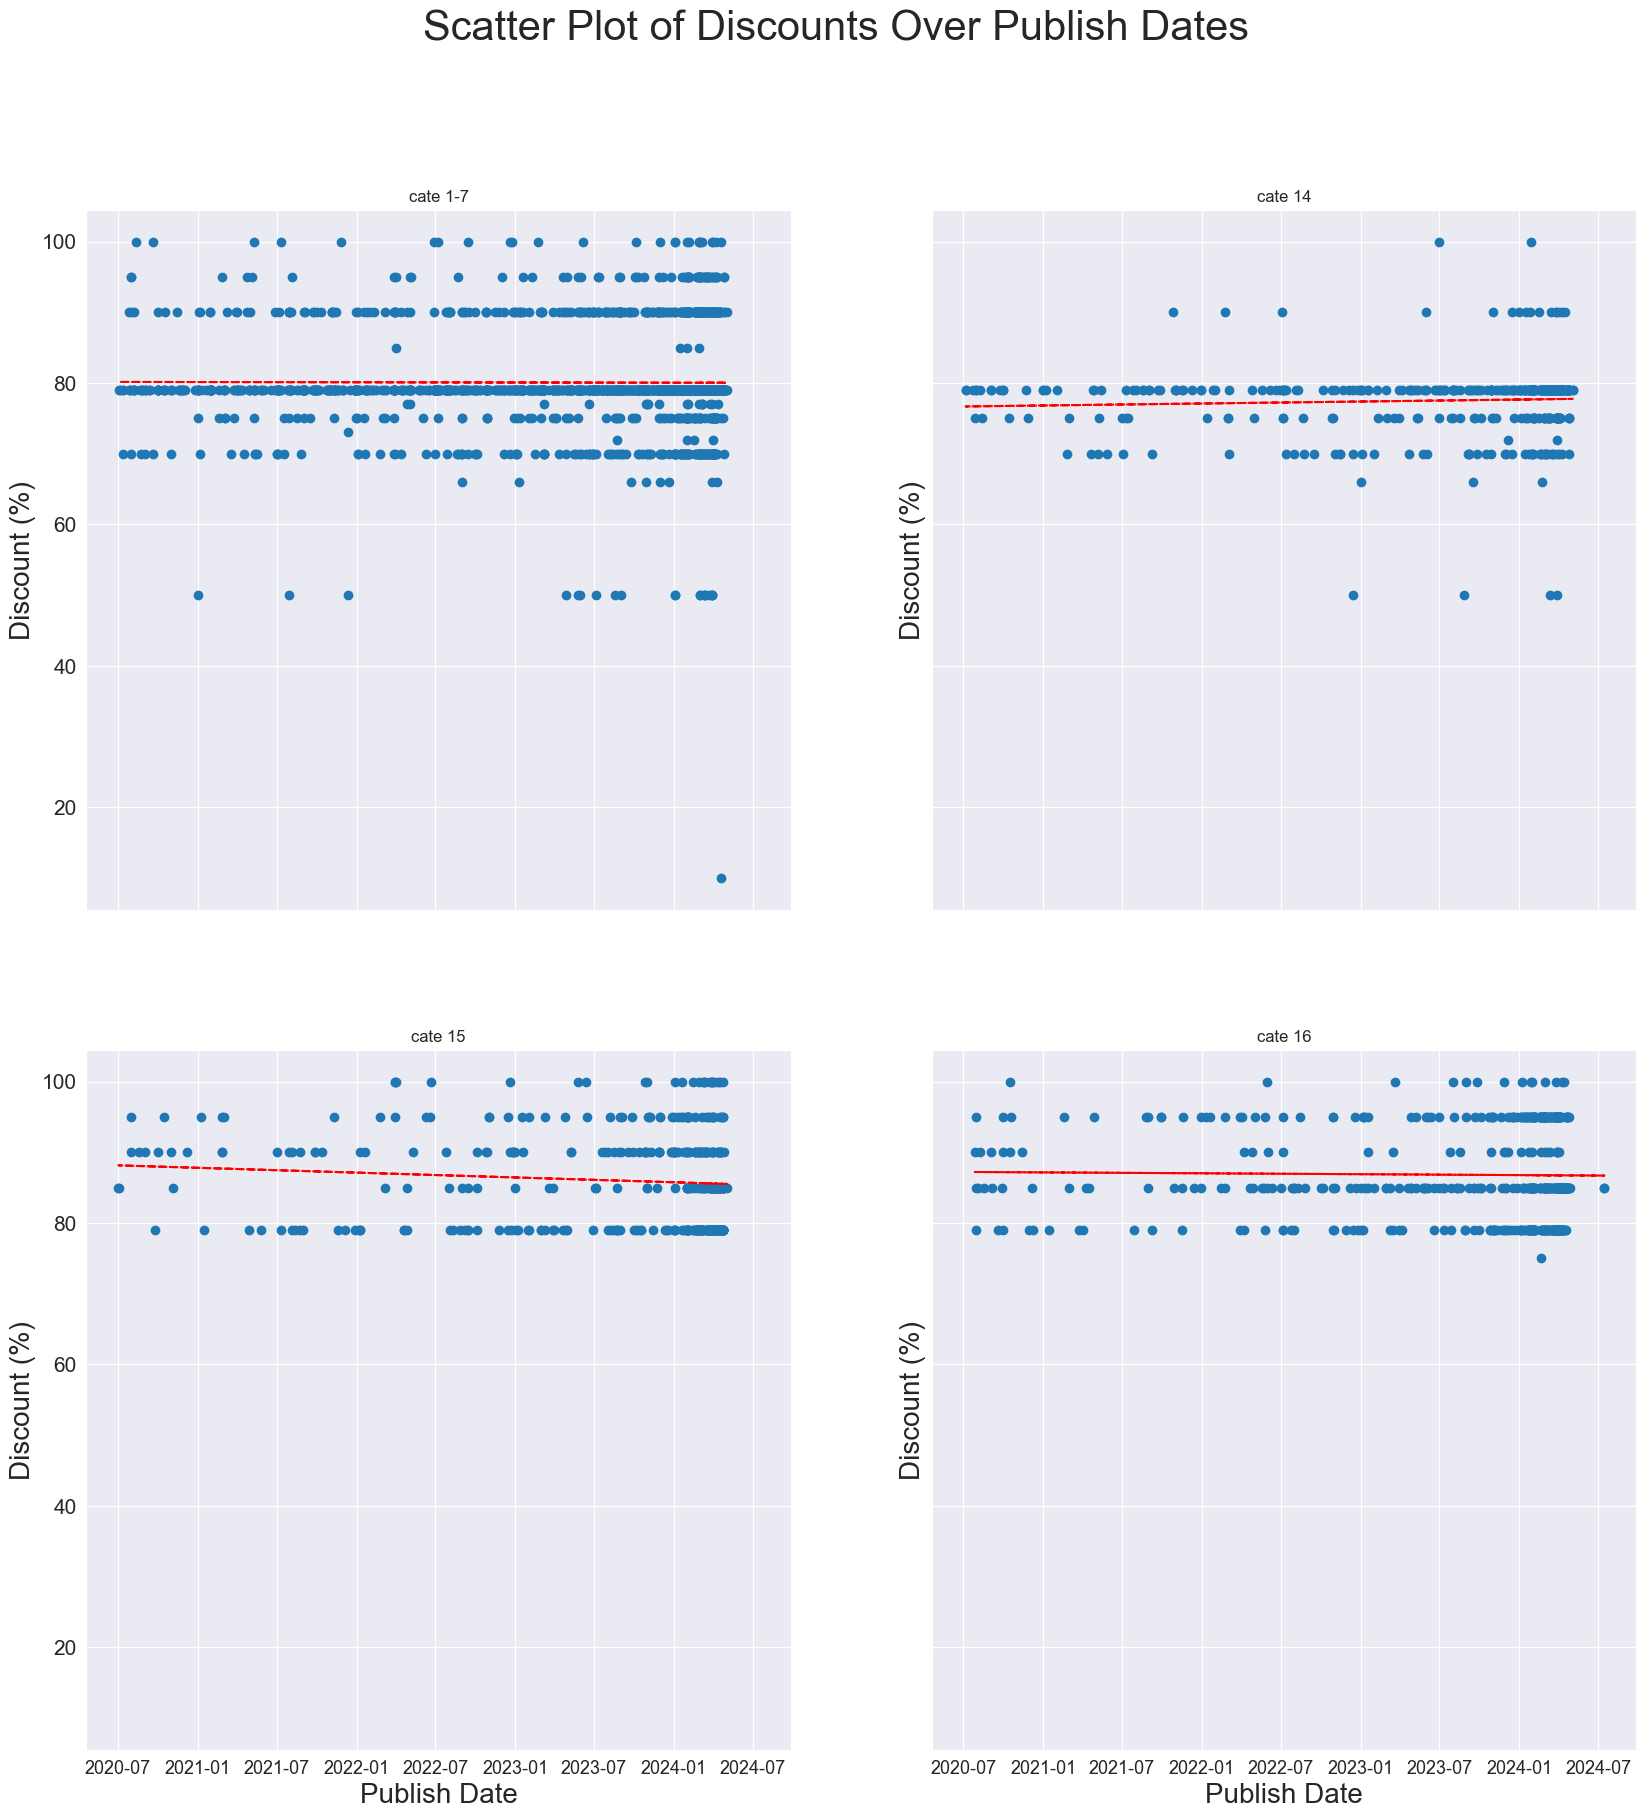

In [8]:
#show the relationship of publish date and discount

fig, axs = plt.subplots(2,2,figsize=(20,20),sharey=True,sharex=True)

subdf = df[(df['publishDate_']>"2020-07-01")]
subdf = subdf.drop_duplicates("title")

mask1 = subdf['cate'].isin([1,2,3,4,5,6,7])
mask2 = subdf['cate'] == 14
mask3 = subdf['cate'] == 15
mask4 = subdf['cate'] == 16

sub1 = subdf[mask1]
sub2 = subdf[mask2]
sub3 = subdf[mask3]
sub4 = subdf[mask4]

axs[0,0].scatter(sub1['publishDate_'], sub1['discount'])
axs[0,0].set_title('cate 1-7')
axs[0,1].scatter(sub2['publishDate_'], sub2['discount'])
axs[0,1].set_title('cate 14')
axs[1,0].scatter(sub3['publishDate_'], sub3['discount'])
axs[1,0].set_title('cate 15')
axs[1,1].scatter(sub4['publishDate_'], sub4['discount'])
axs[1,1].set_title('cate 16')

# add polyfit line in subplots

x1 = mdates.date2num(sub1['publishDate_'])
y1 = sub1['discount']
z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
axs[0,0].plot(x1,p1(x1),"r--")
axs[0,0].set_ylabel('Discount (%)',fontsize=20)
axs[0,0].tick_params(axis='y', which='major', labelsize=15)

x2 = mdates.date2num(sub2['publishDate_'])
y2 = sub2['discount']
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
axs[0,1].plot(x2,p2(x2),"r--")
axs[0,1].set_ylabel('Discount (%)',fontsize=20)
axs[0,1].tick_params(axis='y', which='major', labelsize=15)

x3 = mdates.date2num(sub3['publishDate_'])
y3 = sub3['discount']
z3 = np.polyfit(x3, y3, 1)
p3 = np.poly1d(z3)
axs[1,0].plot(x3,p3(x3),"r--")
axs[1,0].set_xlabel('Publish Date',fontsize=20)
axs[1,0].set_ylabel('Discount (%)',fontsize=20)
axs[1,0].tick_params(axis='y', which='major', labelsize=15)
axs[1,0].tick_params(axis='x', which='major', labelsize=13)

x4 = mdates.date2num(sub4['publishDate_'])
y4 = sub4['discount']
z4 = np.polyfit(x4, y4, 1)
p4 = np.poly1d(z4)
axs[1,1].plot(x4,p4(x4),"r--")
axs[1,1].set_xlabel('Publish Date',fontsize=20)
axs[1,1].set_ylabel('Discount (%)',fontsize=20)
axs[1,1].tick_params(axis='y', which='major', labelsize=15)
axs[1,1].tick_params(axis='x', which='major', labelsize=13)


# Display the plot

plt.suptitle('Scatter Plot of Discounts Over Publish Dates',fontsize=30)
plt.savefig("./pics/publishDate_discount_by_catgory.png")

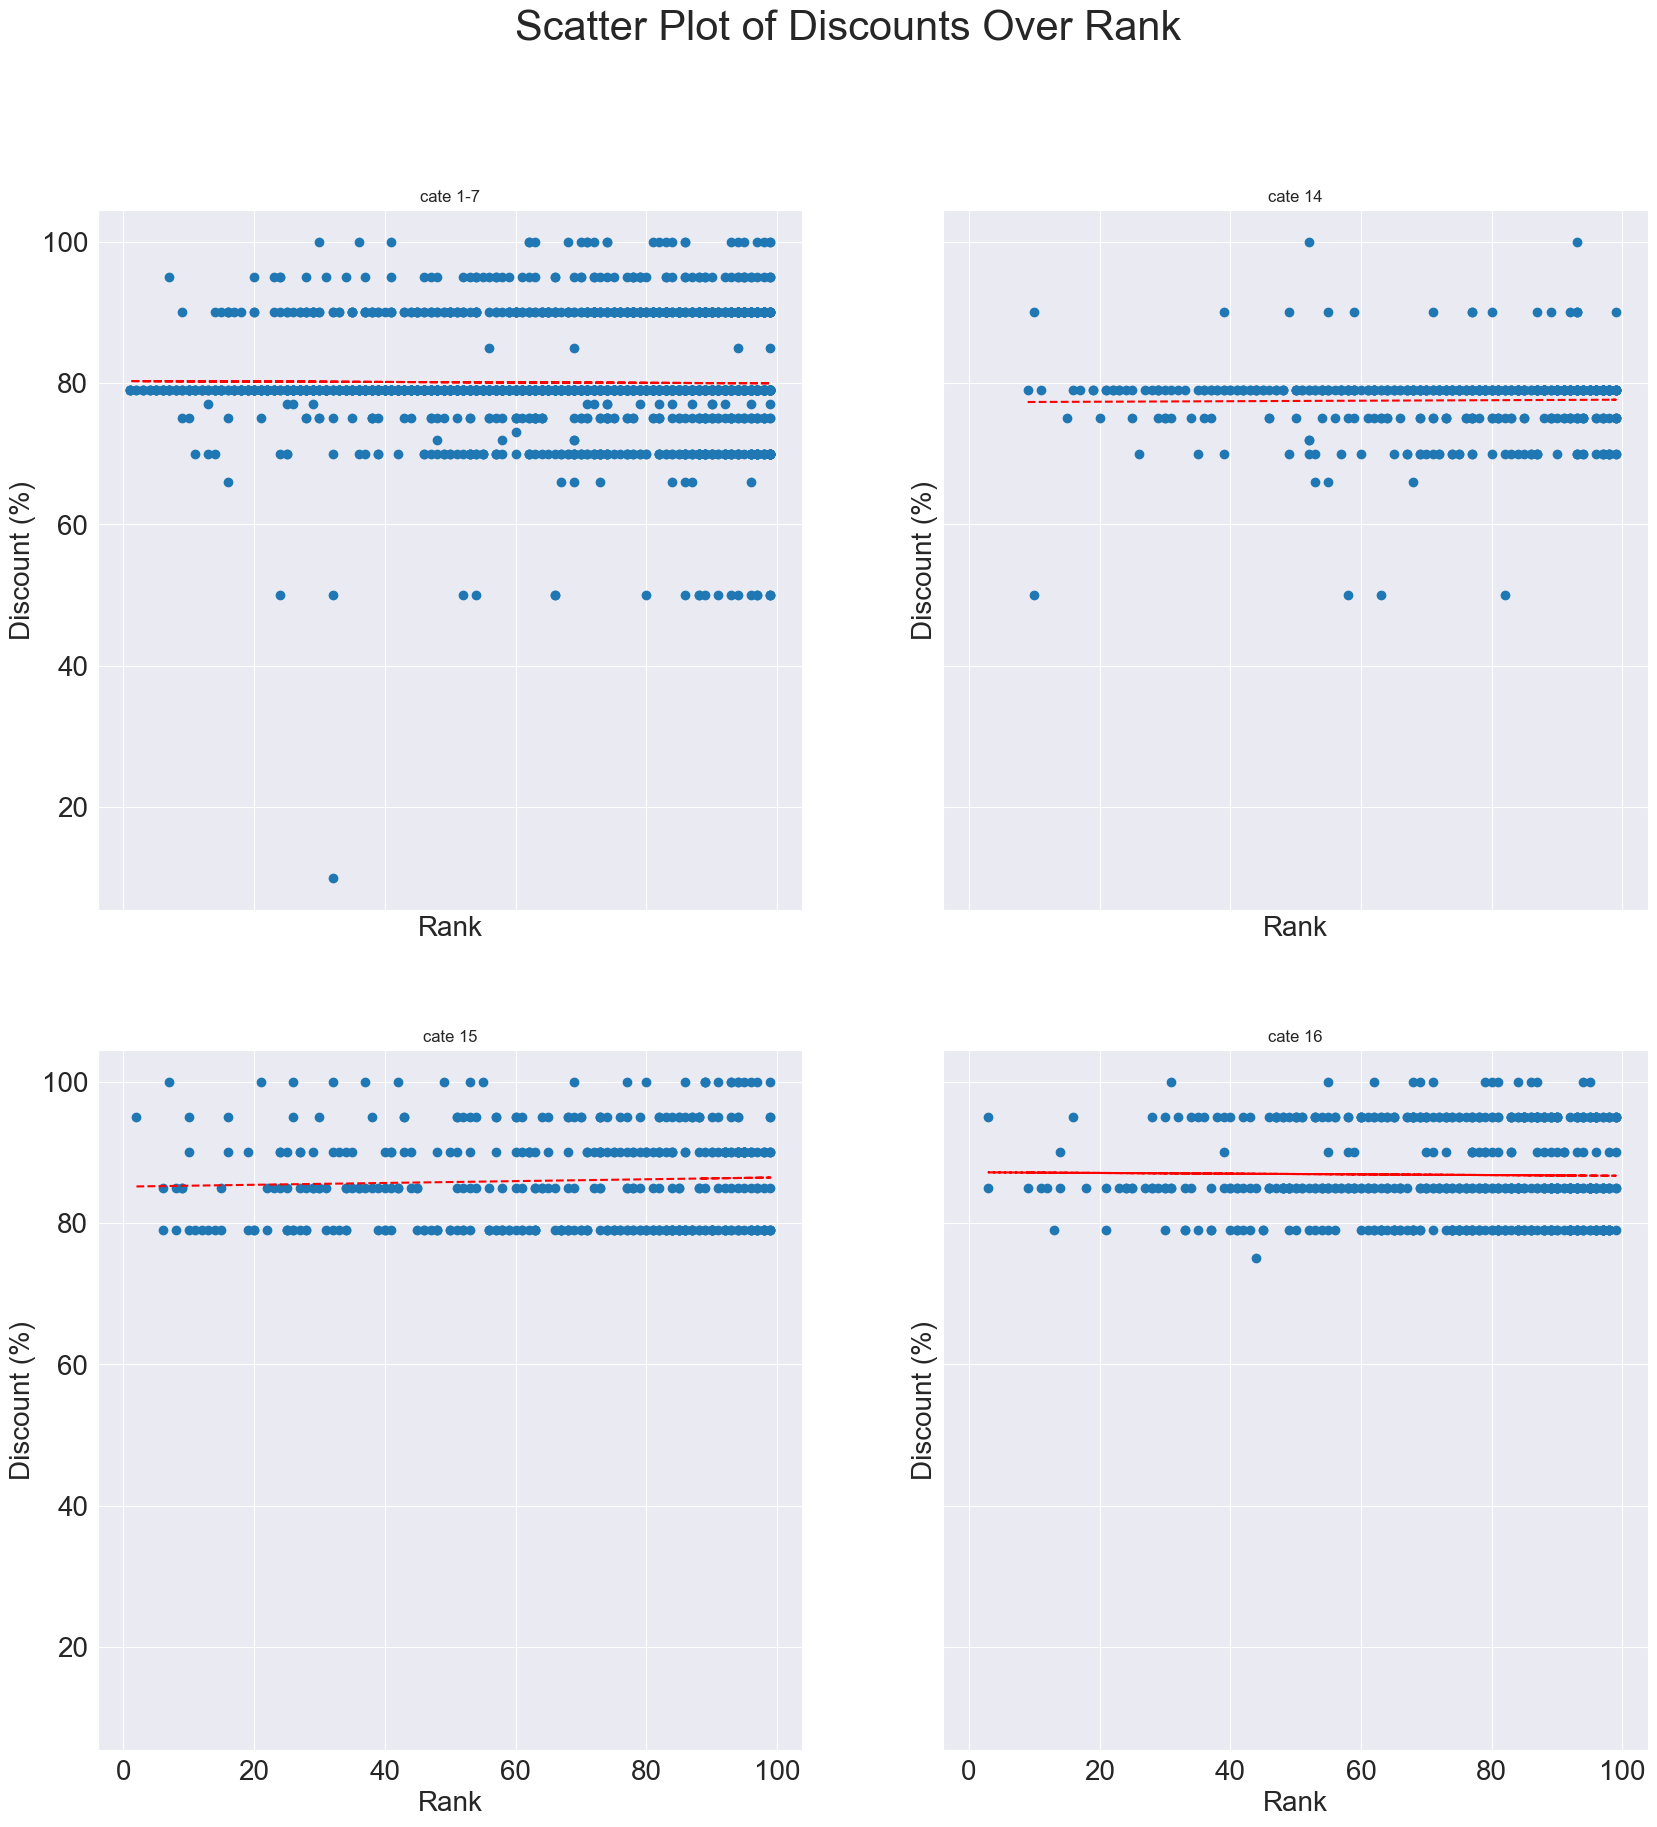

In [21]:
# show the relationship between rank and discount

fig, axs = plt.subplots(2,2,figsize=(20,20),sharey=True,sharex=True)

subdf = df[(df['publishDate_']>"2020-07-01")]
subdf = subdf.drop_duplicates("title")

mask1 = subdf['cate'].isin([1,2,3,4,5,6,7])
mask2 = subdf['cate'] == 14
mask3 = subdf['cate'] == 15
mask4 = subdf['cate'] == 16

sub1 = subdf[mask1]
sub2 = subdf[mask2]
sub3 = subdf[mask3]
sub4 = subdf[mask4]

axs[0,0].scatter(sub1['rank'], sub1['discount'])
axs[0,0].set_title('cate 1-7')
axs[0,1].scatter(sub2['rank'], sub2['discount'])
axs[0,1].set_title('cate 14')
axs[1,0].scatter(sub3['rank'], sub3['discount'])
axs[1,0].set_title('cate 15')
axs[1,1].scatter(sub4['rank'], sub4['discount'])
axs[1,1].set_title('cate 16')

# add polyfit line in subplots

x1 = sub1['rank']
y1 = sub1['discount']
z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
axs[0,0].plot(x1,p1(x1),"r--")
axs[0,0].set_xlabel('Rank',fontsize=20)
axs[0,0].set_ylabel('Discount (%)',fontsize=20)
axs[0,0].tick_params(axis='both', which='major', labelsize=20)

x2 = sub2['rank']
y2 = sub2['discount']
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
axs[0,1].plot(x2,p2(x2),"r--")
axs[0,1].set_xlabel('Rank',fontsize=20)
axs[0,1].set_ylabel('Discount (%)',fontsize=20)
axs[0,1].tick_params(axis='both', which='major', labelsize=20)

x3 = sub3['rank']
y3 = sub3['discount']
z3 = np.polyfit(x3, y3, 1)
p3 = np.poly1d(z3)
axs[1,0].plot(x3,p3(x3),"r--")
axs[1,0].set_xlabel('Rank',fontsize=20)
axs[1,0].set_ylabel('Discount (%)',fontsize=20)
axs[1,0].tick_params(axis='both', which='major', labelsize=20)

x4 = sub4['rank']
y4 = sub4['discount']
z4 = np.polyfit(x4, y4, 1)
p4 = np.poly1d(z4)
axs[1,1].plot(x4,p4(x4),"r--")
axs[1,1].set_xlabel('Rank',fontsize=20)
axs[1,1].set_ylabel('Discount (%)',fontsize=20)
axs[1,1].tick_params(axis='both', which='major', labelsize=20)


# Display the plot

plt.suptitle('Scatter Plot of Discounts Over Rank',fontsize=30)
plt.savefig("./pics/Rank_discount_by_catgory.png")

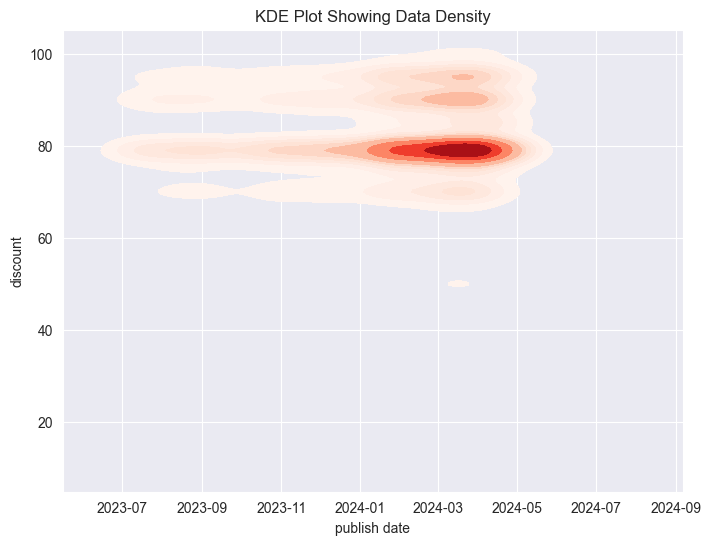

In [10]:
import seaborn as sns

# Generate data

# Create a KDE plot
plt.figure(figsize=(8, 6))
sns.kdeplot(x=subdf['publishDate_'], y=subdf['discount'], cmap="Reds", fill=True)
plt.title('KDE Plot Showing Data Density')
plt.xlabel('publish date')
plt.ylabel('discount')
plt.savefig("./pics/KDE_plot.png",dpi=300)


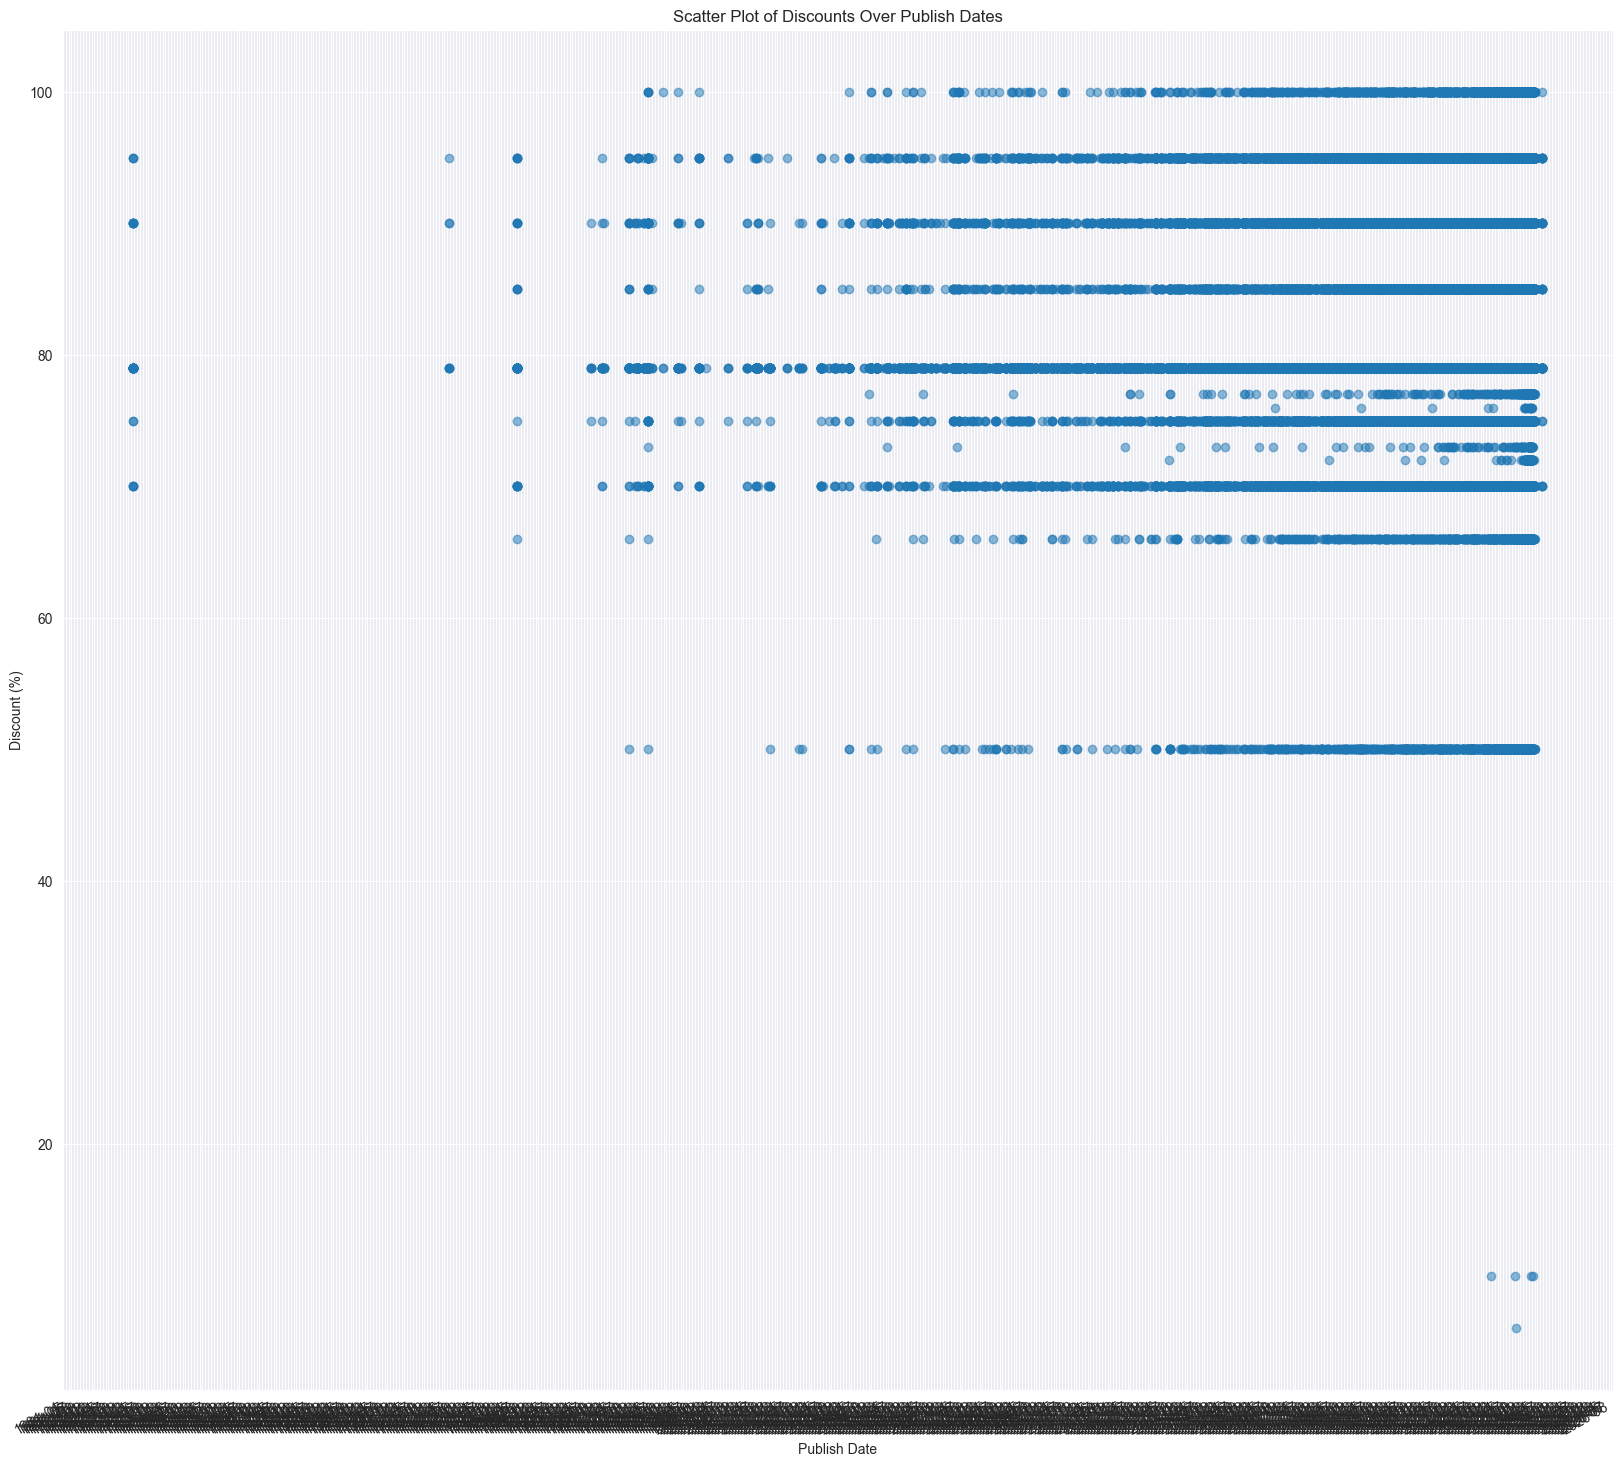

In [17]:
# Convert 'publishDate' from string to datetime format
data = df


# Filter out any rows where 'discount' or 'publishDate' might be missing
filtered_data = data.dropna(subset=['discount', 'publishDate_'])

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a scatter plot
plt.figure(figsize=(20, 20))
plt.scatter(filtered_data['publishDate_'], filtered_data['discount'], alpha=0.5)

# Formatting the plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # setting major ticks locator to month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # formatting the ticks to show year and month
plt.gcf().autofmt_xdate()  # automatically formats the x-axis data to fit better
plt.xlabel('Publish Date')
plt.ylabel('Discount (%)')
plt.title('Scatter Plot of Discounts Over Publish Dates')
plt.grid(True)
plt.show()


In [18]:
def genXY(subdf):
    Y = pd.DataFrame([])
    X = subdf
    try:
        X['attr'] = X['attr'].astype("category")
    except:
        pass
    X = pd.get_dummies(subdf[['attr']],drop_first=True)
    X['rank'] = pd.to_numeric(subdf['rank'])
    X['price'] = pd.to_numeric(subdf['price_'])
    Y['discount'] = pd.to_numeric(subdf['discount'])
    X['days_since_start'] = (subdf['publishDate_'] -  datetime.datetime.strptime("2024-04-22",'%Y-%m-%d')).dt.days
    X = X.fillna(False)
    Y = Y.fillna(False)
    X['days_since_start'] = X['days_since_start'].astype(int)
    for colum in X.columns[X.dtypes == 'bool']:
        X[colum] = X[colum].astype(int)
    return X,Y

In [19]:
df1 = df[df['cate'].isin([i for i in range(1,7)])].drop(['cate'],axis=1).reset_index(drop=True)
df2 = df[df['cate'] == 14].drop(['cate'],axis=1).reset_index(drop=True)
df3 = df[df['cate'] == 15].drop(['cate'],axis=1).reset_index(drop=True)
df4 = df[df['cate'] == 16].drop(['cate'],axis=1).reset_index(drop=True)

X1,Y1 = genXY(df1)
X2,Y2 = genXY(df2)
X3,Y3 = genXY(df3)
X4,Y4 = genXY(df4)


X1_const = sm.add_constant(X1)
model1 = sm.OLS(Y1, X1_const).fit()
X2_const = sm.add_constant(X2)
model2 = sm.OLS(Y2, X2_const).fit()
X3_const = sm.add_constant(X3)
model3 = sm.OLS(Y3, X3_const).fit()
X4_const = sm.add_constant(X4)
model4 = sm.OLS(Y4, X4_const).fit()

In [20]:
print(model1.params,model2.params,model3.params,model4.params,sep="\n\n")

const               7.881465e+01
attr_7             -1.168610e+00
attr_30            -1.287774e+00
rank                9.712769e-03
price               1.795040e-03
days_since_start    4.549030e-07
dtype: float64

const               79.472288
attr_7              -2.167696
attr_30             -2.300882
rank                -0.004158
price               -0.001695
days_since_start     0.000072
dtype: float64

const               80.901426
attr_7              -0.508860
attr_30              0.651548
rank                 0.020402
price                0.014297
days_since_start    -0.000090
dtype: float64

const               87.021726
attr_7              -0.511007
attr_30              0.613322
rank                -0.006492
price                0.005186
days_since_start    -0.000073
dtype: float64


In [21]:
def scatter_plot(df,xaxis,yaxis, cmap,datelimit = "2023-07-01"):
    fig_, axs_ = plt.subplots(3, 3, figsize=(30, 30), sharey=True)
    
    subdf_ = df[(df['publishDate_'] > datelimit)]
    subdf_ = subdf_.drop_duplicates("title")
    
    masks = []
    subs = []
    cats = [1,2,3,4,6,7,14,15,16]
    for i in cats:
        masks.append(subdf_['cate'] == i)
    for i in masks:
        subs.append(subdf_[i])
    for i in range(3):
        for j in range(3):
            axs_[i,j].scatter(subs[i*3+j][xaxis],subs[i*3+j][yaxis])
            axs_[i,j].set_title(f'category {cats[i*3+j]}',fontsize=40)
            if subs[i*3+j][xaxis].dtype == "<M8[ns]":
                x = mdates.date2num(subs[i*3+j][xaxis])
            else:
                x = subs[i*3+j][xaxis]
            y = subs[i*3+j][yaxis]
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            axs_[i,j].plot(x, p(x), "r--")
        
        
    """
    mask1 = subdf['cate'].isin([1,2,3,4,5,6,7])
    mask2 = subdf['cate'] == 14
    mask3 = subdf['cate'] == 15
    mask4 = subdf['cate'] == 16
    
    sub1 = subdf_[mask1]
    sub2 = subdf_[mask2]
    sub3 = subdf_[mask3]
    sub4 = subdf_[mask4]
    
    axs_[0,0].scatter(sub1['publishDate_'], sub1['discount'])
    axs_[0,0].set_title('cate 1-7')
    axs_[0,1].scatter(sub2['publishDate_'], sub2['discount'])
    axs_[0,1].set_title('cate 14')
    axs_[1,0].scatter(sub3['publishDate_'], sub3['discount'])
    axs_[1,0].set_title('cate 15')
    axs_[1,1].scatter(sub4['publishDate_'], sub4['discount'])
    axs_[1,1].set_title('cate 16')
    
    
    # add polyfit line in subplots
    
    x1 = mdates.date2num(sub1['publishDate_'])
    y1 = sub1['discount']
    z1 = np.polyfit(x1, y1, 1)
    p1 = np.poly1d(z1)
    axs_[0,0].plot(x1, p1(x1), "r--")
    x2 = mdates.date2num(sub2['publishDate_'])
    y2 = sub2['discount']
    z2 = np.polyfit(x2, y2, 1)
    p2 = np.poly1d(z2)
    axs_[0,1].plot(x2, p2(x2), "r--")
    x3 = mdates.date2num(sub3['publishDate_'])
    y3 = sub3['discount']
    z3 = np.polyfit(x3, y3, 1)
    p3 = np.poly1d(z3)
    axs_[1,0].plot(x3, p3(x3), "r--")
    x4 = mdates.date2num(sub4['publishDate_'])
    y4 = sub4['discount']
    z4 = np.polyfit(x4, y4, 1)
    p4 = np.poly1d(z4)
    axs_[1,1].plot(x4, p4(x4), "r--")
    
    """
    # Display the plot
    plt.suptitle(f"Scatter Plot of {yaxis} Over {xaxis}",fontsize=50)
    # plt.show()
    plt.savefig(f"./pics/scatter_plot_{xaxis}_{yaxis}.png",dpi=300)
    

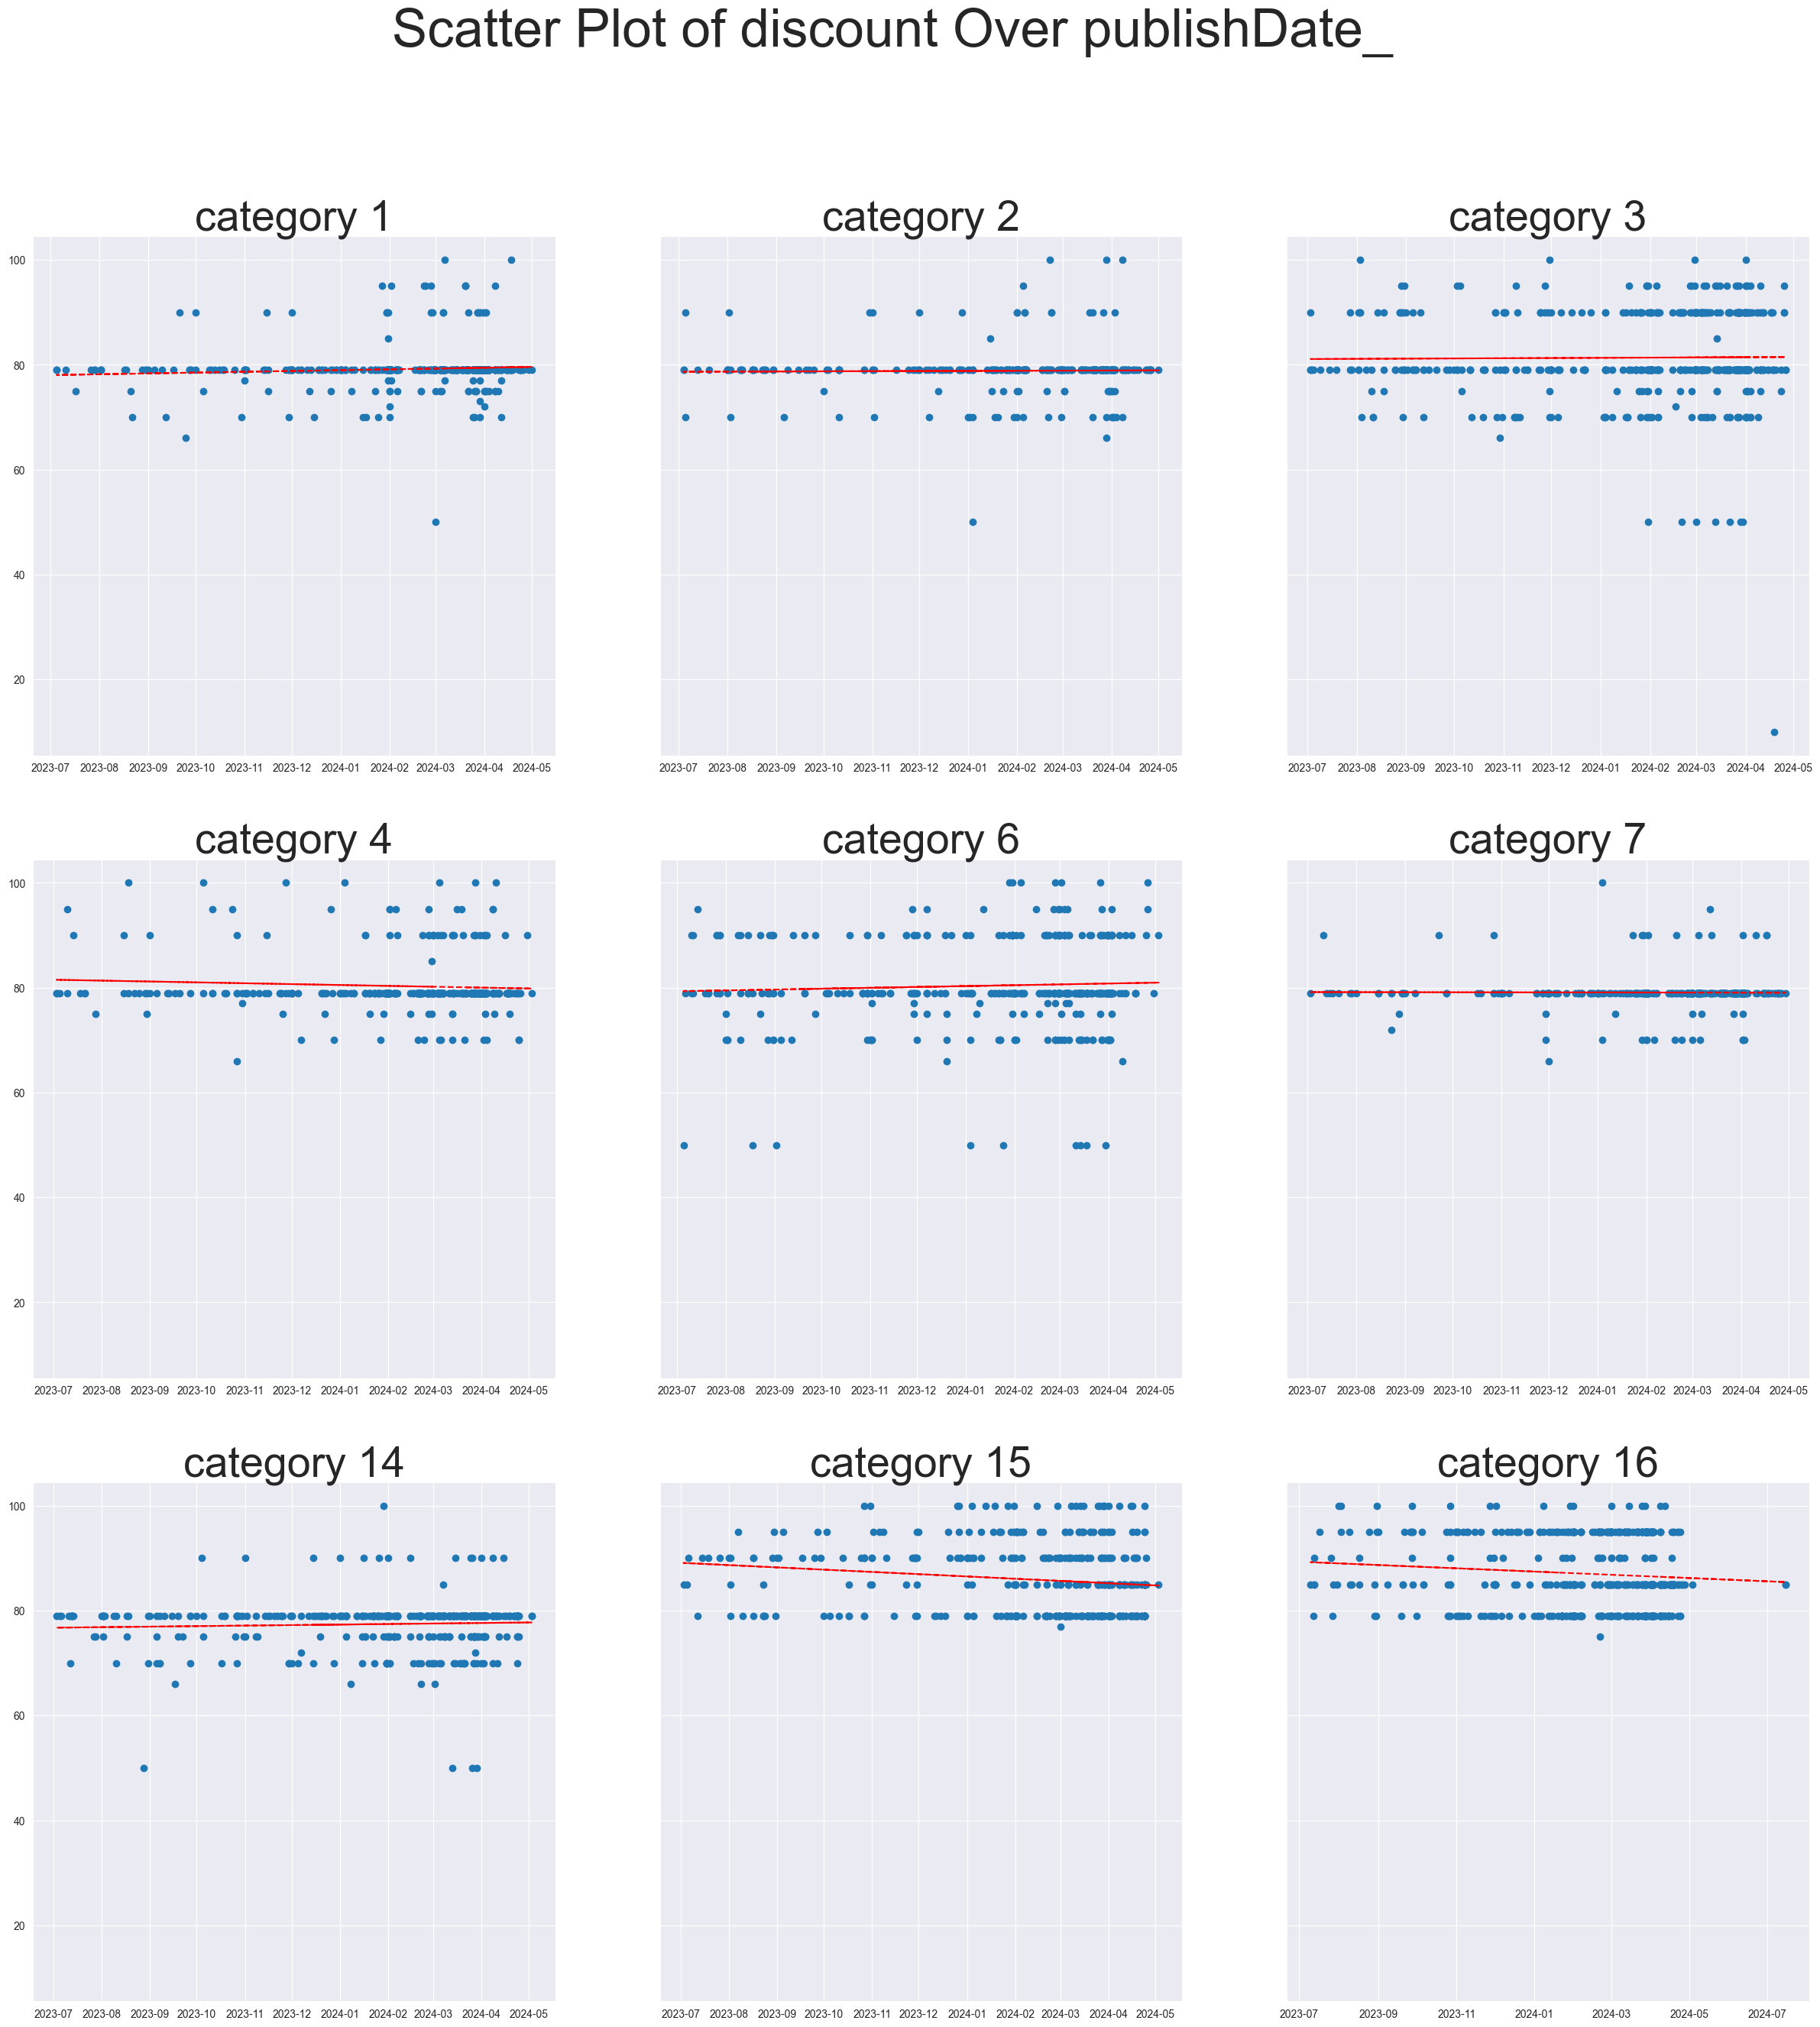

In [22]:
scatter_plot(df,"publishDate_","discount",cate_map)


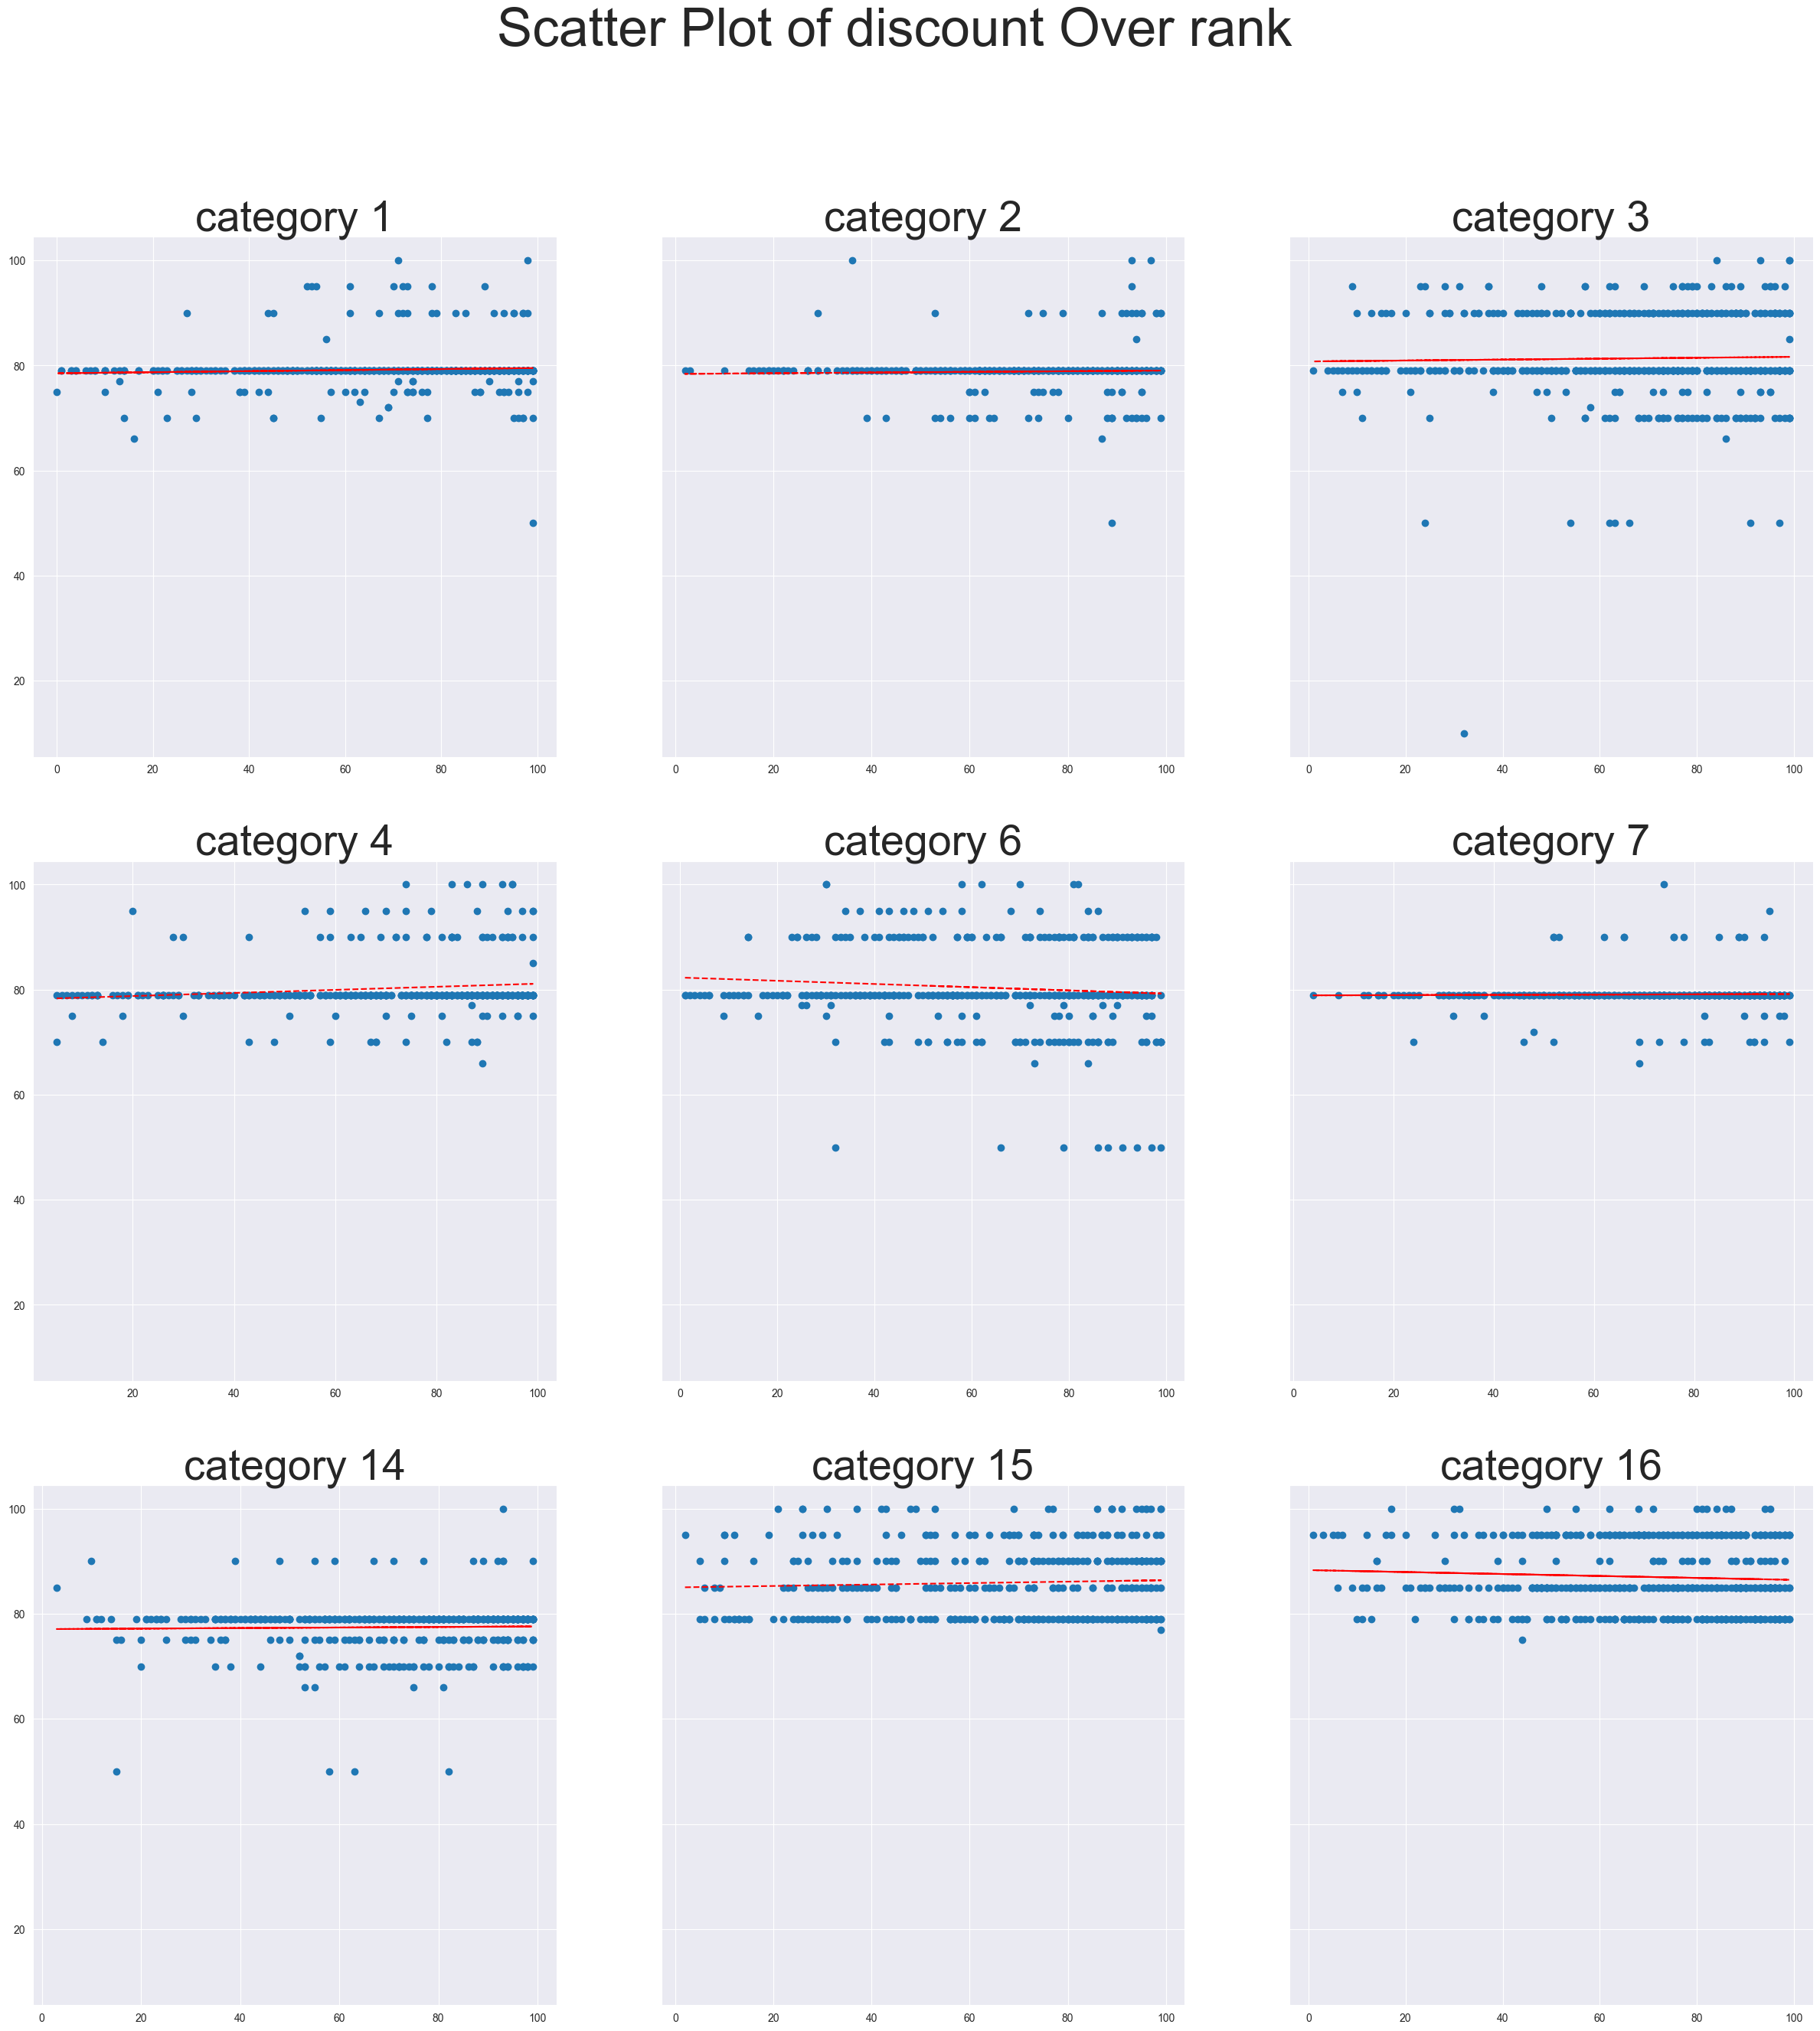

In [23]:
scatter_plot(df, "rank", "discount", cate_map)

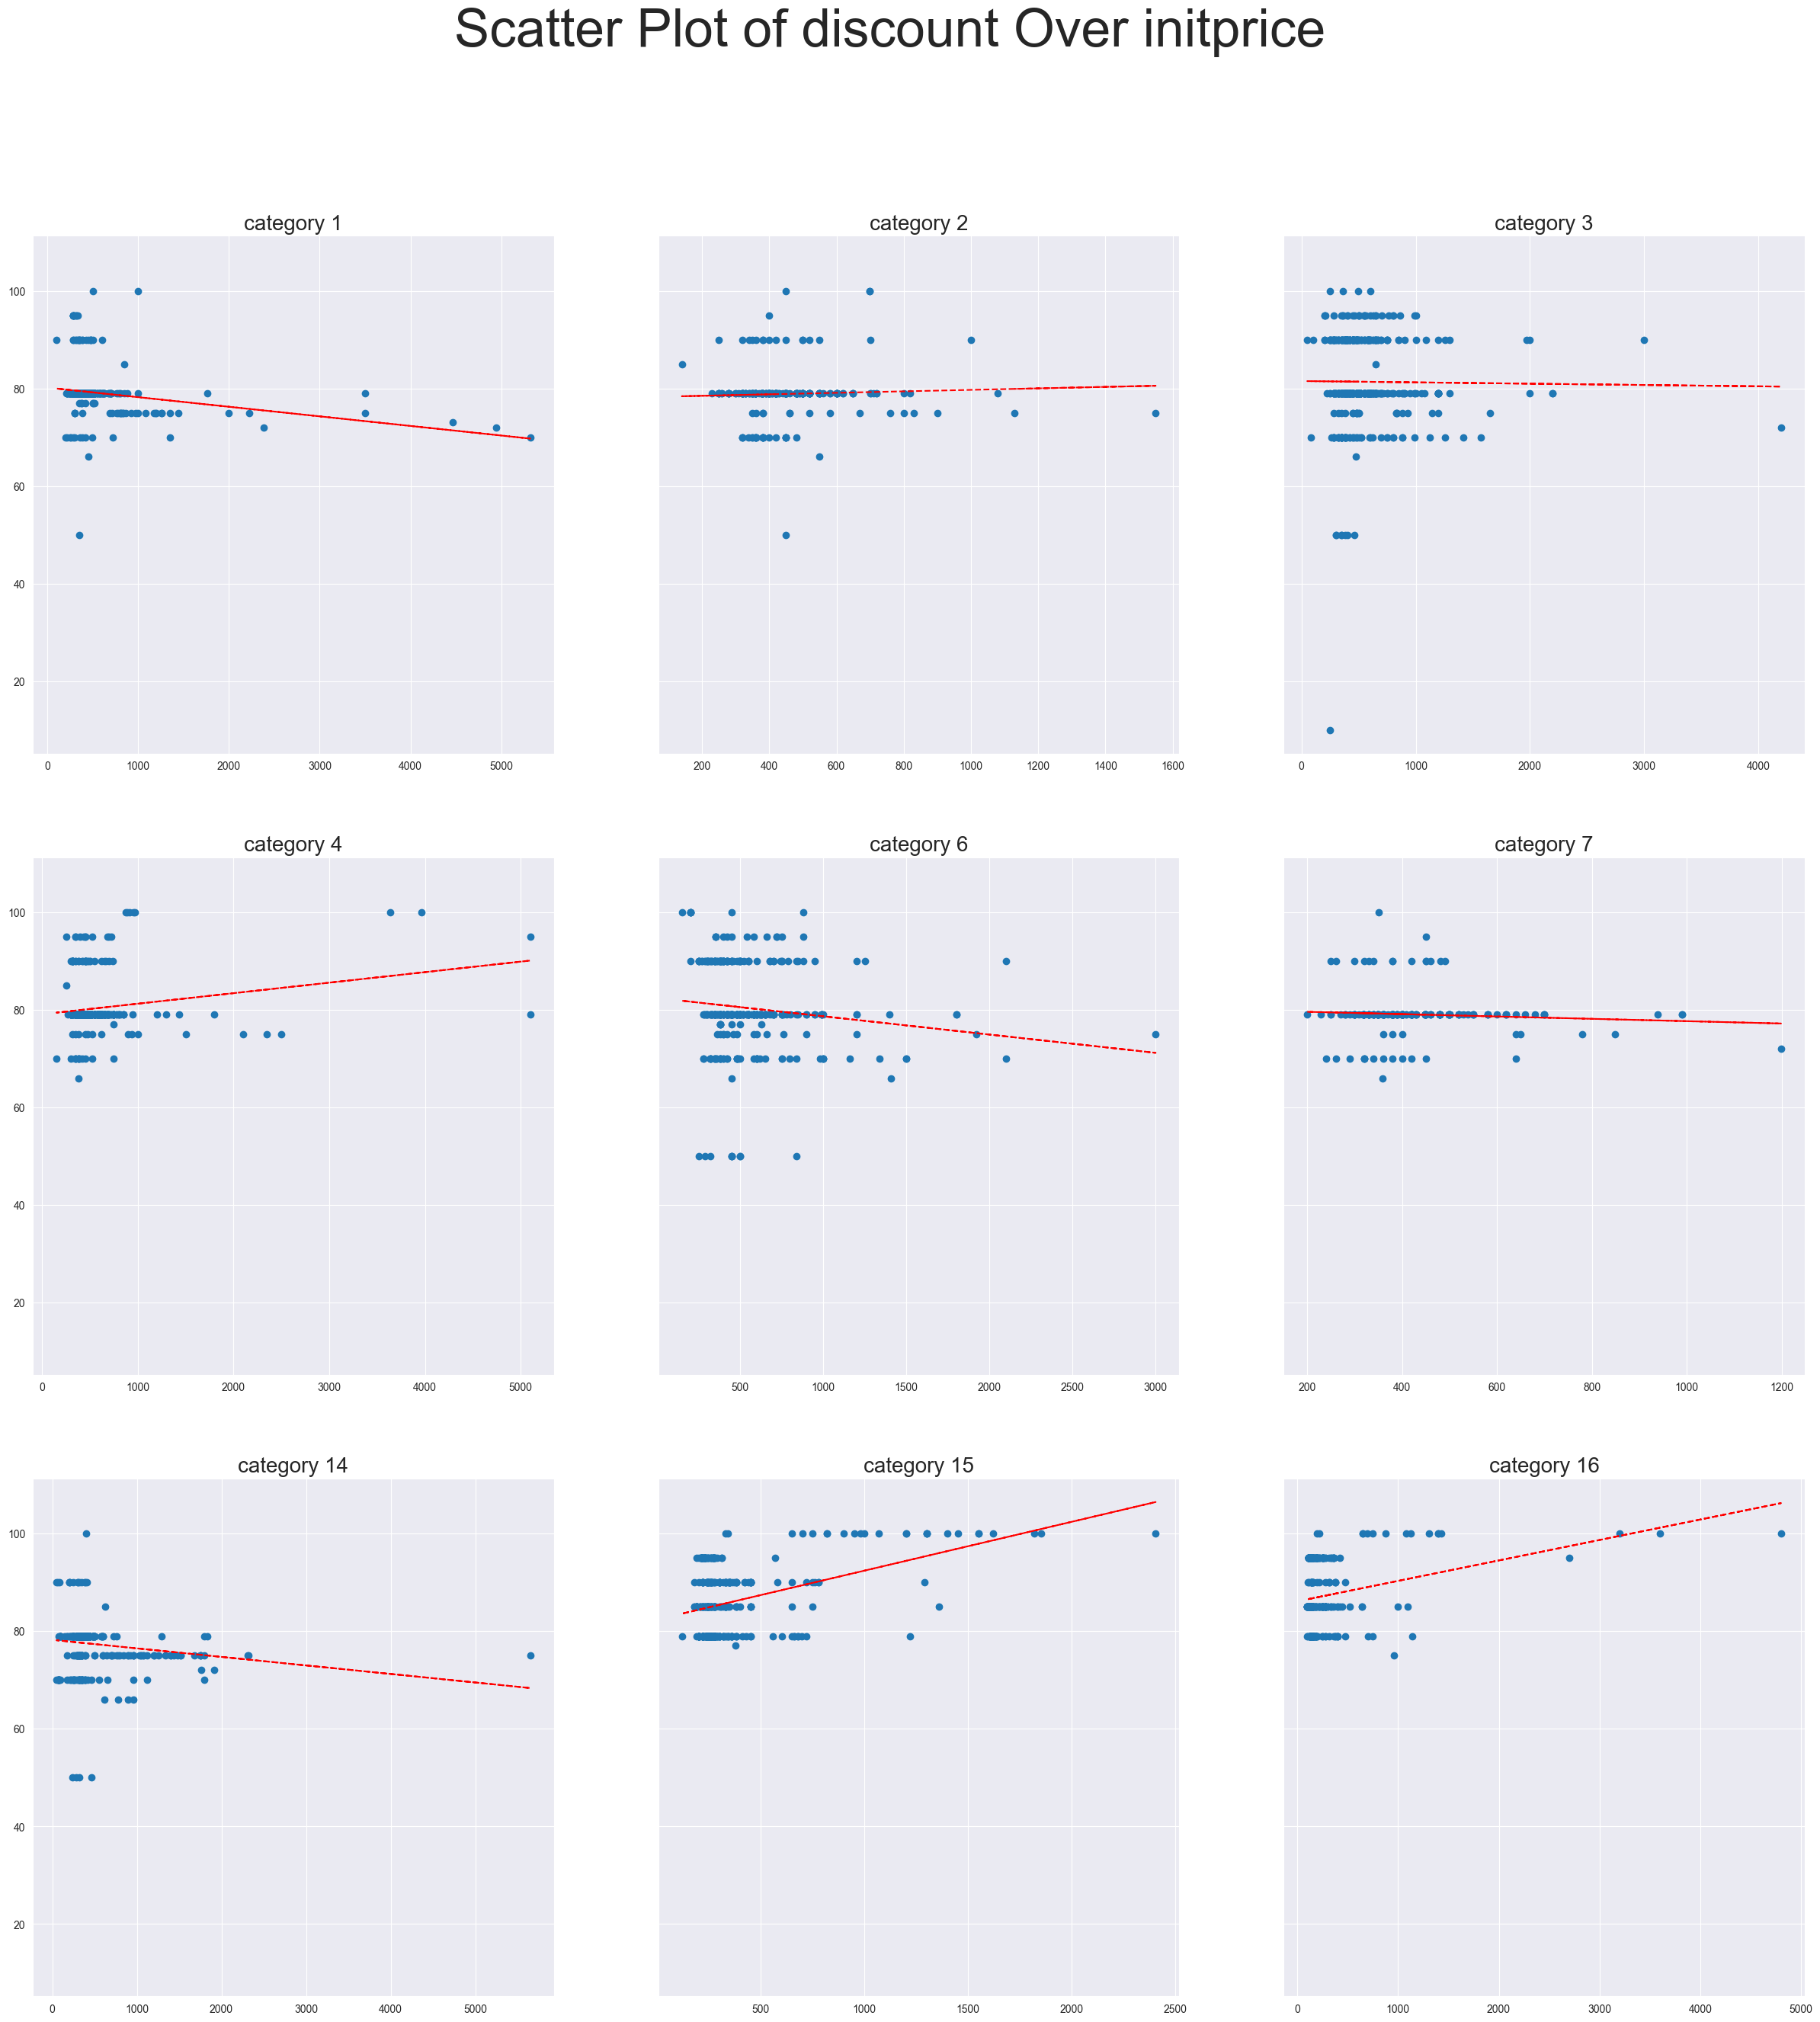

In [40]:
scatter_plot(df, "initprice", "discount", cate_map)

In [41]:
m1 = df['discount'] == 100
m2 = df['type'] != 2

<BarContainer object of 16 artists>

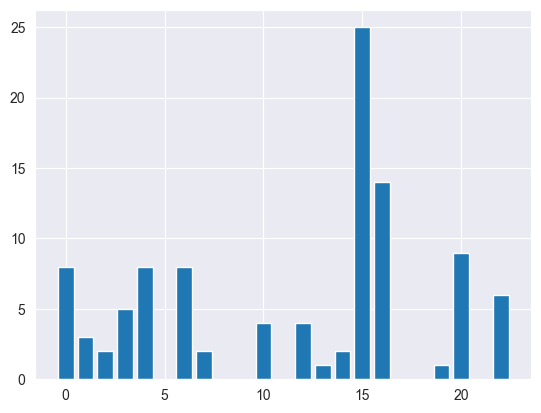

In [42]:
temp = df[(m1) & (m2)].drop_duplicates("title").groupby('cate').count().iloc[:,0]
plt.bar(temp.index,temp)

In [18]:
df[df['publisher'] == "時報出版"].drop_duplicates("title")

,title,rank,cate,attr,date,discount,type,price_,publishDate_,publisher
15,消失的愛：逆轉我們的時代（博客來獨家印簽版）,15,0,7,2024-04-26,79,0,379,2024-03-22,時報出版
31,鑄劍為犁：賴幸媛的兩岸談判秘辛,31,0,7,2024-04-26,79,0,379,2024-02-20,時報出版
49,底層邏輯：看清這個世界的底牌,49,0,7,2024-04-26,79,0,316,2022-03-29,時報出版
74,離開舒適圈之後，抵達成熟之前：一場奇幻的海外職場大冒險,74,0,7,2024-04-26,79,0,300,2024-04-23,時報出版
112,牧羊少年奇幻之旅【繪圖本】（在台暢銷50萬冊紀念版）,12,1,7,2024-04-26,79,0,284,2021-10-26,時報出版
...,...,...,...,...,...,...,...,...,...,...
224651,手工派塔的基礎 ：只用2種基礎麵團，做出美味甜鹹派、法式布丁塔、千層點心，網路接單、小資創業...,31,0,0,2024-04-07,79,2,434,2024-01-30,時報出版
224652,【精裝經典故事集套書】（二冊）：《希臘羅馬神話》、《莎士比亞故事集》,32,0,0,2024-04-07,75,2,598,2024-03-26,時報出版
224668,動物生態解剖書：揭祕世界各地野生動物的奇妙習性與生活,48,0,0,2024-04-07,79,2,379,2024-04-02,時報出版
224740,經濟學超圖解（新裝版）,26,0,0,2024-04-10,79,2,379,2024-01-23,時報出版


In [15]:
time

cate
0     116
1     190
2     186
3     241
4     217
6     188
7     184
8     239
9     203
10    200
11    174
12    205
13    161
14    198
15    203
16    210
17    182
18    174
19    161
20    199
22    160
Name: title, dtype: int64